In [1]:
# Earnings Analysis 

In [2]:
!pip install yfinance  nasdaq-data-link quandl python-dotenv termcolor

## Stock Universe

In [3]:
# Cell 1: Import Libraries
import requests
import pandas as pd
import os
from dotenv import load_dotenv
from datetime import datetime
import io
import matplotlib.pyplot as plt
import calendar
import ipywidgets as widgets
from IPython.display import display
from termcolor import colored


# Load environment variables from .env file
load_dotenv()

# Read the API key from environment variable
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

## Earnings Calendar

In [4]:
# Function to fetch earnings calendar data
def fetch_earnings_calendar(symbol, api_key, horizon='3month'):
    url = f'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol={symbol}&horizon={horizon}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.content.decode('utf-8')
        return pd.read_csv(io.StringIO(data))
    else:
        print(f"Failed to fetch data for {symbol}. Status code: {response.status_code}")
        return None

# Function to fetch and organize earnings calendar data for baskets
def get_earnings_calendar(baskets, api_key, horizon=3):
    earnings_calendar = []
    end_date = datetime.now() + pd.DateOffset(months=horizon)
    for basket_name, symbols in baskets.items():
        for symbol in symbols:
            earnings = fetch_earnings_calendar(symbol, api_key, horizon=f'{horizon}month')
            if earnings is not None:
                for index, row in earnings.iterrows():
                    earnings_date = pd.to_datetime(row['reportDate'])
                    if earnings_date <= end_date:
                        earnings_calendar.append({
                            'Basket': basket_name,
                            'Symbol': symbol,
                            'Date': row['reportDate'],
                            'EPS': row.get('epsEstimate', 'N/A')  # Use .get() to avoid KeyError
                        })
    df = pd.DataFrame(earnings_calendar)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Function to print earnings calendar
def print_earnings_calendar(earnings_calendar_df):
    earnings_calendar_df['Date'] = pd.to_datetime(earnings_calendar_df['Date'])
    print(f"Earnings Calendar for the Next {horizon} Months:")
    for basket in earnings_calendar_df['Basket'].unique():
        print(f"\nBasket: {basket}")
        basket_data = earnings_calendar_df[earnings_calendar_df['Basket'] == basket].sort_values(by='Date')
        for index, row in basket_data.iterrows():
            print(f"Ticker: {row['Symbol']}, Earnings Date: {row['Date'].strftime('%Y-%m-%d')}, EPS Estimate: {row['EPS']}")

# Function to assign colors to each basket
def assign_text_colors(baskets):
    colors = ['red', 'green', 'yellow', 'blue', 'magenta', 'cyan']
    color_map = {basket: colors[i % len(colors)] for i, basket in enumerate(baskets)}
    return color_map

# Enhanced function to print earnings by date with colors
def print_earnings_by_date(earnings_calendar_df):
    earnings_calendar_df['Date'] = pd.to_datetime(earnings_calendar_df['Date'])
    grouped = earnings_calendar_df.groupby('Date').apply(lambda x: ', '.join(x['Symbol'] + ' (' + x['Basket'] + ')')).reset_index(name='Symbol')
    
    color_map = assign_text_colors(earnings_calendar_df['Basket'].unique())
    
    print("Earnings by Date:")
    for index, row in grouped.iterrows():
        symbols = row['Symbol']
        colored_symbols = []
        for symbol in symbols.split(', '):
            ticker, basket = symbol.split(' (')
            basket = basket.rstrip(')')
            colored_symbols.append(colored(ticker, color_map[basket]))
        print(f"{row['Date'].strftime('%Y-%m-%d')}: {', '.join(colored_symbols)}")
    
    print("\nLegend:")
    for basket, color in color_map.items():
        print(colored(basket, color))

### Define interested Stock Lists

In [5]:
# Cell 2 and 4 Combined: Define Stock Groups, Automate Dictionary Creation, and Create Baskets
semiconductor = ['NVDA', 'AVGO', 'AMD', 'DELL', 'MU', 'INTC', 'QCOM', 'CSCO', 'MRVL', 'SMCI', 'ASML', 'ON', 'MPWR', 'APLD', 'AEHR']
cybersecurity = ['PANW', 'NET', 'CRWD', 'FTNT','HACK','ZS']
mag_7 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG', 'META', 'TSLA']
crypto = ['MARA', 'RIOT', 'HIVE', 'MSTR', 'HUT', 'IREN', 'SOS', 'WULF', 'CLSK', 'CORZ', 'BTBT', 'SQ', 'COIN']
software_ai = ['SNOW','HUBS','HCP','DUOL','SHOP','MDB','ORCL','CRM','DOCU','TWLO','KVYO','SNAP','NOW','DDOG','PLTR','CART']
energy=['CEG','VST']

def create_group(name, symbols):
    unique_symbols = list(set(symbols))  # Ensure unique tickers
    return {name: {'name': name.capitalize(), 'symbols': unique_symbols}}

# Function to create a basket of stocks
def create_basket(groups):
    basket = {}
    for group_name, symbols in groups.items():
        group = create_group(group_name, symbols)
        for name, group_info in group.items():
            basket[group_info['name']] = group_info['symbols']
    return basket

# Filter out Jupyter internal variables and dynamically retrieve group names and symbols
all_vars = globals()
groups = {k: v for k, v in all_vars.items() if isinstance(v, list) and k in ['semiconductor', 'cybersecurity', 'mag_7', 'crypto']}

# Create baskets
baskets = create_basket(groups)
print(baskets)  # To verify the structure

# The rest of the code remains unchanged

{'Semiconductor': ['NVDA', 'MPWR', 'DELL', 'AMD', 'ASML', 'APLD', 'MRVL', 'ON', 'INTC', 'SMCI', 'AEHR', 'CSCO', 'QCOM', 'AVGO', 'MU'], 'Cybersecurity': ['NET', 'CRWD', 'PANW', 'FTNT', 'ZS', 'HACK'], 'Mag_7': ['NVDA', 'MSFT', 'AAPL', 'GOOG', 'TSLA', 'AMZN', 'META'], 'Crypto': ['SQ', 'IREN', 'COIN', 'CORZ', 'SOS', 'BTBT', 'RIOT', 'HUT', 'HIVE', 'MARA', 'MSTR', 'CLSK', 'WULF']}


### Get and Print earnings dates

In [6]:
# Set the horizon in months
horizon = 3

# Define all groups (ensure this matches your basket groups)
all_groups = {
    'Semiconductor': semiconductor,
    'Cybersecurity': cybersecurity,
    'Mag_7': mag_7,
    'Crypto': crypto
}

# Create selected_baskets
selected_baskets = create_basket(all_groups)

# Fetch and organize the data
earnings_calendar_df = get_earnings_calendar(selected_baskets, api_key, horizon)

# Print the earnings calendar
# print_earnings_calendar(earnings_calendar_df)

# Print the earnings by date
print_earnings_by_date(earnings_calendar_df)

Earnings by Date:
2024-08-08: CLSK
2024-08-09: HIVE
2024-08-12: HUT, WULF
2024-08-13: BTBT
2024-08-14: CSCO
2024-08-19: PANW
2024-08-28: NVDA, CRWD, NVDA
2024-08-29: DELL, MRVL
2024-09-02: ZS
2024-09-05: AVGO
2024-09-13: IREN
2024-09-23: SOS
2024-09-25: MU
2024-10-03: AEHR
2024-10-07: APLD
2024-10-16: ASML
2024-10-18: TSLA
2024-10-22: MSFT, GOOG
2024-10-23: META
2024-10-24: INTC, AMZN
2024-10-28: MPWR, ON
2024-10-29: AMD
2024-10-30: SMCI, QCOM, MSTR
2024-10-31: NET, FTNT, AAPL, SQ, COIN
2024-11-01: CORZ
2024-11-04: IREN
2024-11-05: RIOT
2024-11-06: MARA

Legend:
Semiconductor
Cybersecurity
Mag_7
Crypto


/var/folders/wd/r6dvw4896gxcrcr84m33fv240000gp/T/ipykernel_25362/291597966.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = earnings_calendar_df.groupby('Date').apply(lambda x: ', '.join(x['Symbol'] + ' (' + x['Basket'] + ')')).reset_index(name='Symbol')


### Plot Earnings Calendar

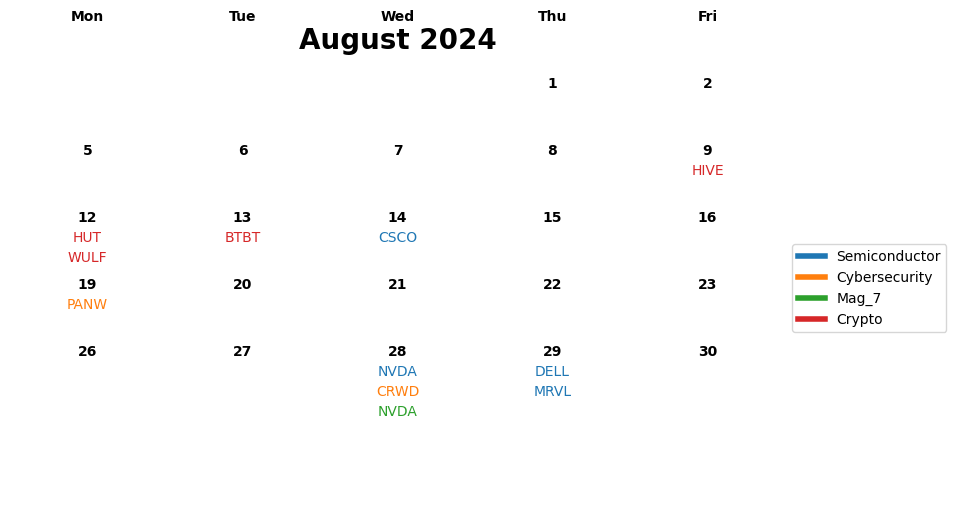

In [7]:
# Cell 5: Plot Earnings Calendar
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def assign_colors(baskets):
    cmap = plt.get_cmap('tab10')
    colors = cmap.colors[:len(baskets)]
    color_map = {basket: colors[i] for i, basket in enumerate(baskets)}
    return color_map

def plot_earnings_calendar(df, month, year, horizon=3):
    df['Date'] = pd.to_datetime(df['Date'])

    # Calculate the end date based on the horizon
    end_date = datetime.now() + pd.DateOffset(months=horizon)
    start_date = datetime.now()

    # Filter data for the given horizon
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Filter data for the given month and year
    month_df = df[(df['Date'].dt.month == month) & (df['Date'].dt.year == year)]
    
    # Create a calendar
    cal = calendar.monthcalendar(year, month)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted size to remove weekends
    ax.set_axis_off()
    
    # Define month and weekday names
    month_name = calendar.month_name[month]
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    
    # Plot month name and year
    ax.set_title(f"{month_name} {year}", fontsize=20, weight='bold')
    
    # Plot weekdays
    for i, day in enumerate(weekdays):
        ax.text(i + 0.5, 6.5, day, ha='center', va='center', weight='bold')
    
    # Assign colors dynamically for each basket
    color_map = assign_colors(df['Basket'].unique())
    
    # Calculate the maximum number of tickers for any single day
    max_tickers = month_df.groupby(month_df['Date'].dt.day).size().max() if not month_df.empty else 0
    
    # Plot days, dates, and tickers
    for week_num, week in enumerate(cal):
        for day_num, day in enumerate(week[:5]):  # Only include Monday to Friday
            if day != 0:
                tickers = month_df[month_df['Date'].dt.day == day]
                date_text = f"{day}"
                ax.text(day_num + 0.5, 5.5 - week_num, date_text, ha='center', va='center', weight='bold')  # Plot the date
                if not tickers.empty:
                    for line_num, (idx, row) in enumerate(tickers.iterrows()):
                        ticker = row['Symbol']
                        basket_name = row['Basket']
                        color = color_map.get(basket_name, 'black')
                        ax.text(day_num + 0.5, 5.5 - week_num - (line_num + 1) * 0.3, ticker, ha='center', va='center', color=color)  # Plot each ticker below the date
    
    # Adjust plot limits based on the maximum number of tickers
    ax.set_xlim(0, 5)
    ax.set_ylim(-1, 6.5 - max(0, (max_tickers - 1) * 0.3))
    
    # Add a legend
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=basket) for basket, color in color_map.items()]
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot
    
    plt.show()

# Function to update calendar plot
def update_calendar(change):
    month = month_selector.value
    year = year_selector.value
    selected_lists = [checkbox.description for checkbox in list_selectors if checkbox.value]
    selected_baskets = create_basket({name: groups[name.lower()] for name in selected_lists})
    earnings_calendar_df = get_earnings_calendar(selected_baskets, api_key, horizon=horizon)
    clear_output(wait=True)
    display_controls()
    plot_earnings_calendar(earnings_calendar_df, month, year, horizon=horizon)

# Create interactive widgets for month, year selection, and list selection
month_selector = widgets.IntSlider(value=datetime.now().month, min=1, max=12, step=1, description='Month:')
year_selector = widgets.IntSlider(value=datetime.now().year, min=datetime.now().year - 1, max=datetime.now().year + 1, step=1, description='Year:')
list_selectors = [widgets.Checkbox(value=True, description=group) for group in all_groups.keys()]

# Function to display controls
def display_controls():
    control_box = widgets.VBox([month_selector, year_selector] + list_selectors)
    display(widgets.HBox([control_box]))

# Link the widgets to the update function
for selector in list_selectors:
    selector.observe(update_calendar, names='value')
month_selector.observe(update_calendar, names='value')
year_selector.observe(update_calendar, names='value')

# Display the initial controls
display_controls()
update_calendar(None)

# GET EARNINGS CALL TRANSCRIPTS

In [12]:
# GET EARNINGS CALL TRANSCRIPTS USIGN FINNHUB API
import requests 
import os   
from dotenv import load_dotenv

load_dotenv()

# Finnhub API key
FINNHUB_API_KEY = os.getenv('FINNHUB_API_KEY')

def get_earnings_transcripts(symbol, api_key):
    url = f'https://finnhub.io/api/v1/earnings_calendar?symbol={symbol}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch data for {symbol}. Status code: {response.status_code}")
        return None


In [10]:
!pip install finnhub-python

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

finnhub_api_key = os.getenv('FINNHUB_API_KEY')
print(f"Finnhub API Key: {finnhub_api_key}")

Finnhub API Key: cr8a87hr01qmmifq4ai0cr8a87hr01qmmifq4aig


In [3]:
def get_earnings_transcripts(symbol):
    # Get the earnings calendar
    earnings_calendar = finnhub_client.earnings_calendar(_from="2022-01-01", to="2023-12-31", symbol=symbol)
    
    print(f"Earnings calendar for {symbol}:")
    print(earnings_calendar)
    
    if earnings_calendar and 'earningsCalendar' in earnings_calendar:
        if len(earnings_calendar['earningsCalendar']) > 0:
            latest_call = earnings_calendar['earningsCalendar'][0]
            call_id = latest_call.get('id')
            
            if call_id:
                # Get the transcript for the latest earnings call
                transcript = finnhub_client.transcripts(call_id)
                return transcript
        else:
            print(f"No earnings calls found for {symbol} in the specified date range.")
    else:
        print(f"Unexpected response format for {symbol}")
    
    return None

# Example usage
symbol = 'AAPL'
transcript = get_earnings_transcripts(symbol)
if transcript:
    print(f"Transcript for {symbol}:")
    print(transcript['transcript'])
else:
    print(f"No transcript available for {symbol}")

Earnings calendar for AAPL:
{'earningsCalendar': []}
No earnings calls found for AAPL in the specified date range.
No transcript available for AAPL


In [13]:
# import finnhub
# finnhub_client = finnhub.Client(api_key=finnhub_api_key)
# print(finnhub_client.transcripts('AAPL_162777'))

import finnhub
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

In [30]:
import requests

url = 'https://v2.api.earningscall.biz/transcript'
params = {
    'apikey': 'demo',
    'exchange': 'nasdaq',
    'symbol': 'aapl',
    'year': '2023',
    'quarter': '2'
}

response = requests.get(url, params=params)
if response.status_code == 200:
    transcript_data = response.json()
    print(transcript_data)
else:
    print(f"Error: {response.status_code}")
    print(response.text)

{'event': {'year': 2023, 'quarter': 2, 'conference_date': '2023-05-04T14:00:00.000-07:00'}, 'text': "And welcome to the Apple Q2 fiscal year 2023 earning conference call. Today's call is being recorded. After this time for opening remarks and introductions, I would like to turn the call over to Suhasini Trindamalli, Director of Investor Relations. Please go ahead. Thank you. Good afternoon, and thank you for joining us. Speaking first today is Apple CEO Tim Cook, and he'll be followed by CFO Luca Maestri. After that, we'll open the call to questions from analysts. Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements, including, without limitation, those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation, and future business outlook, including the potential impact of macroeconomic conditions on the company's business and results of operations. These statements inv

In [36]:
import requests

url = 'https://v2.api.earningscall.biz/transcript'
params = {
    'apikey': 'demo',
    'exchange': 'nasdaq',
    'symbol': 'aapl',
    'year': '2023',
    'quarter': '1',
    'level': '2'
}

response = requests.get(url, params=params)
if response.status_code == 200:
    transcript_data = response.json()
    print(transcript_data)
else:
    print(f"Error: {response.status_code}")
    print(response.text)


{'event': {'year': 2023, 'quarter': 1, 'conference_date': '2023-02-02T17:00:00.000-05:00'}, 'speakers': [{'speaker': 'spk12', 'text': "Good day, everyone, and welcome to the Apple Q1 Fiscal Year 2023 Earnings Conference Call. Today's call is being recorded. And now at this time, for opening remarks and introductions, I would like to turn the call over to Teja Skala, Director of Investor Relations and Corporate Finance. Please go ahead."}, {'speaker': 'spk07', 'text': "Thank you. Speaking first today is Apple CEO Tim Cook, and he'll be followed by CFO Luca Maestri. After that, we'll open the call to questions from analysts. Before turning the call over to Tim, I would like to remind everyone that the December quarter spanned 14 weeks, while the March quarter, as usual, has 13 weeks. Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements including, without limitation, those regarding revenue, gross margin, operating exp